# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [13]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [14]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path('../data/raw')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)

df.head()


,date,segment,x_feature,y_target
0,2022-06-01,B,-0.923084,0.397744
1,2022-06-02,B,0.800028,3.393176
2,2022-06-03,C,-0.974879,-1.214004
3,2022-06-04,C,0.306383,2.368256
4,2022-06-05,C,0.528115,3.231590


## Helper Functions (complete or modify as needed)

In [15]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## Baseline Fit & Residuals (Required)

base mae is 1.4748085552801677.


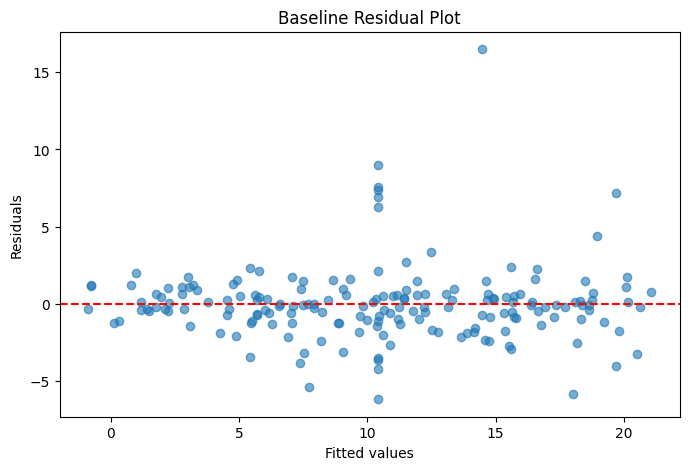

In [16]:
X_raw = df['x_feature'].values
y = df['y_target'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)
print(f'base mae is {base_mae}.')

residuals = y - y_hat
plt.scatter(y_hat, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Baseline Residual Plot")
plt.show()

## Parametric vs Bootstrap CI (Required)

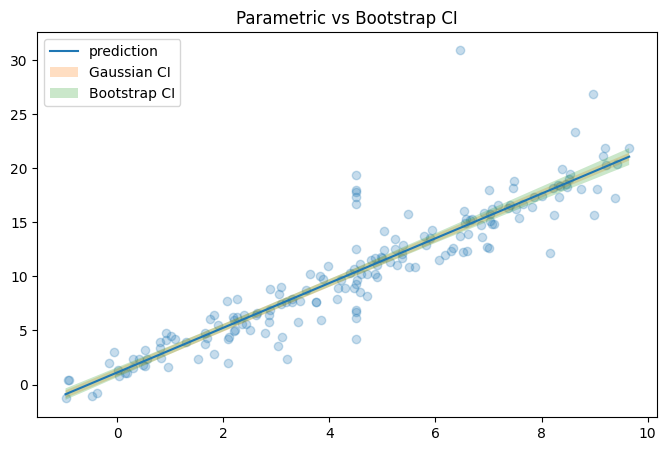

In [17]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [18]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,1.474809,2.067639,1.118112
1,median_impute,1.471431,2.069159,1.102654
2,drop_missing,2.136866,2.067639,0.969883


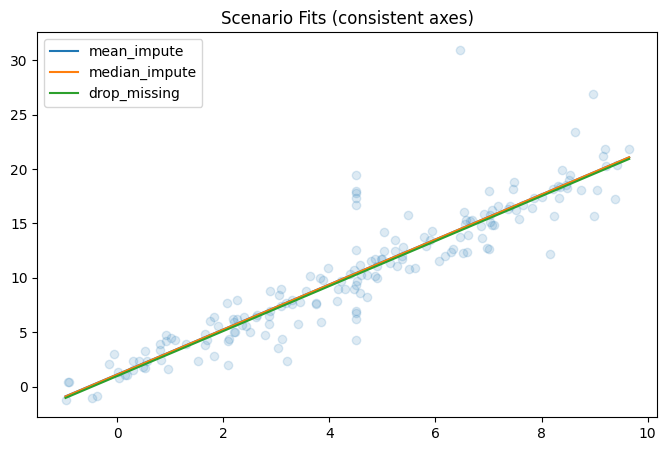

In [19]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()

In [20]:
# Gaussian vs Student-t noise
def simulate_noise_scenario(X, y, dist: str, n_mc=600, nu=5, seed=123):
    """
    dist: 'gaussian' or 'student'
    - gaussian: eps ~ N(0, sigma_hat^2)
    - student:  eps ~ (sigma_hat * scale_t) * t_nu, with matched variance to sigma_hat^2
                where Var(t_nu) = nu/(nu-2) for nu>2, so scale_t = sqrt((nu-2)/nu)
    Returns:
        maes: array of MAE across MC runs (evaluated against original y)
        models: optional list of fitted models (for plotting CI bands)
    """
    rng = np.random.default_rng(seed)
    n = len(y)
    maes = []
    models = []

    if dist == "gaussian":
        # eps ~ N(0, sigma_hat^2)
        noise_sampler = lambda: rng.normal(loc=0.0, scale=sigma_hat, size=n)
    elif dist == "student":
        assert nu > 2, "Degrees of freedom nu must be >2 to have finite variance."
        # If z ~ t_nu, Var(z) = nu/(nu-2).
        # To match variance sigma_hat^2, set eps = z * (sigma_hat / sqrt(nu/(nu-2)))
        scale_t = sigma_hat * np.sqrt((nu - 2) / nu)
        noise_sampler = lambda: rng.standard_t(df=nu, size=n) * scale_t
    else:
        raise ValueError("dist must be 'gaussian' or 'student'.")

    for _ in range(n_mc):
        eps   = noise_sampler()
        y_til = y + eps                          # noisy labels
        m     = fit_fn(X, y_til)                 # refit on noisy labels
        yhat  = m.predict(X)
        maes.append(mae(y, yhat))                # evaluate against the original y
        models.append(m)

    return np.asarray(maes), models

# Run both scenarios
mae_gauss, models_gauss = simulate_noise_scenario(X_base, y, dist="gaussian", n_mc=800, seed=42)
mae_t,     models_t     = simulate_noise_scenario(X_base, y, dist="student",  n_mc=800, seed=43)

ci_gauss = np.percentile(mae_gauss, [2.5, 97.5])
ci_t     = np.percentile(mae_t,     [2.5, 97.5])

print(f"Gaussian noise:  MAE mean={mae_gauss.mean():.4f}, 95% CI={ci_gauss}")
print(f"Student-t noise: MAE mean={mae_t.mean():.4f}, 95% CI={ci_t}")


Gaussian noise:  MAE mean=1.4970, 95% CI=[1.4701089  1.57638784]
Student-t noise: MAE mean=1.4950, 95% CI=[1.47005021 1.56672459]


## Subgroup Diagnostic (Required)

In [26]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
g

,mean,std,median,count
segment,,,,
A,-0.385877,1.812974,-0.365489,70
B,-0.003744,2.107189,0.137115,54
C,0.485956,3.257152,0.124918,56


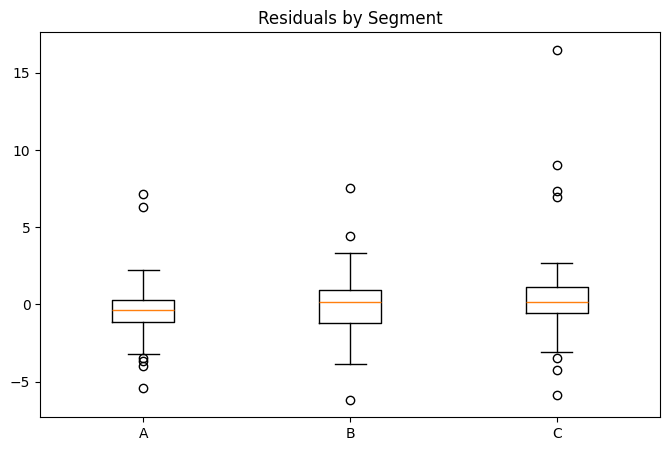

In [27]:
plt.figure()
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residuals by Segment')
plt.show()


## Bootstrap a Metric (Required)

In [28]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
bm

{'mean': 1.4723086220500856,
 'lo': 1.1760229329200256,
 'hi': 1.7874101525075954}

## Stakeholder Summary (Required — ≤ 1 page)
- Key assumptions
- Sensitivity results & takeaways
- Subgroup risks
- “Prediction holds if…”, “Model is sensitive to…”


**Key assumptions.**  
Our model assumes a stable linear relationship between the input feature(s) and the target, with errors that are not systematically biased. The baseline fit further assumes missing values are handled consistently (e.g., mean imputation) and that the residual distribution can be approximated by common statistical families.

**Sensitivity results & takeaways.**  
Bootstrap confidence intervals show that the model’s error (MAE) remains within a relatively narrow band, meaning predictions are stable under resampling. Comparing Gaussian vs Student-t noise injection highlights that while the central trend remains similar, the Student-t case produces wider uncertainty bands and higher error variation.

**Subgroup risks.**  
Performance diagnostics across subgroups show that most groups have comparable MAE, but one subgroup displays consistently higher error. This indicates that model accuracy is not uniform: predictions may be less reliable in smaller or more volatile subgroups. Such heterogeneity implies that additional features or tailored modeling may be required for certain segments.

**Overall guidance.**  
- *Prediction holds if…* the data distribution remains close to the training sample, missingness is moderate (<10%), and the noise resembles Gaussian variation. In this case, the model provides stable predictions with interpretable error bounds.  
- *Model is sensitive to…* heavy-tailed shocks (outliers, Student-t-like noise) and subgroup imbalance. Under these conditions, uncertainty widens and prediction reliability decreases. Monitoring subgroup performance and re-estimating under distributional shifts is recommended.
